In [29]:
import pandas as pd

In [4]:
import numpy as np
from lookup import lookup
import os
 
# Get the list of all files and directories
path = "C:/Users/dioge/Code/GitHub/2023-FRIB-TA-Summer-School/model-mixing/RBMSecar/Emulator/Results"
dir_list = os.listdir(path)

class CozyMatrix:
    def __init__(self,path):
        file = open(path,"r")
        self.matrices = []
        local_mat = 331*[0]
        count = 1
        for line in file:
            count += 1
            vec = line.split()
            if vec[0] == "L" or vec[0] == "P" or vec[0] == "A" or vec[0][0] == "-":
                continue
            if vec[0] == "I" and len(local_mat)!=0:
                self.matrices.append(local_mat)
                #print(local_mat)
                local_mat = 331*[0]
            elif vec[0] != "I":
                word = ""
                for i in range(3,len(vec)):
                    word+=vec[i]
                try:
                    local_mat[lookup[word]-1] = float(vec[1])
                except:
                    print(word,count)     

In [5]:
big_matrix = []
for i in range(len(dir_list)):
    M1 = CozyMatrix(path+"/"+dir_list[i])
    big_row = []
    for mat in M1.matrices:
        for row in mat:
            big_row.append(row)
    big_matrix.append(big_row)

In [9]:
len(big_matrix)

2648

In [10]:
u,s,v = np.linalg.svd(big_matrix)

In [11]:
s

array([2.22572830e+04, 1.24469756e+03, 9.71357820e+01, 4.42029811e+00,
       3.06242999e-01, 1.10772952e-01, 2.61755422e-02, 9.02353076e-03,
       1.64627563e-03, 8.44177723e-04, 5.93147408e-04, 3.25076036e-04,
       1.23825073e-04, 6.88312550e-05, 5.17262714e-05, 3.01025217e-05,
       2.19315474e-05, 1.79822761e-05, 1.36837175e-05, 5.42587367e-06,
       3.94909442e-06, 2.67317516e-06, 1.83773410e-06, 1.29643501e-06,
       8.10368723e-07, 6.58449321e-07, 5.12205880e-07, 3.02651659e-07,
       2.66293975e-07, 1.90041738e-07, 1.42274570e-07, 1.12526433e-07,
       9.02184350e-08, 8.60115912e-08, 5.53511889e-08, 4.37956938e-08,
       3.23129059e-08, 2.82108492e-08, 2.05453557e-08, 1.41191879e-08,
       1.29006959e-08, 9.10016631e-09, 8.68248323e-09, 5.79694124e-09,
       3.96818649e-09, 2.88710854e-09, 2.48486082e-09, 1.87046085e-09,
       1.52877456e-09, 1.40358050e-09, 1.14897487e-09, 8.42039435e-10,
       6.59615894e-10, 5.91339831e-10, 5.31720978e-10, 4.69900042e-10,
      

In [12]:
import matplotlib.pyplot as plt

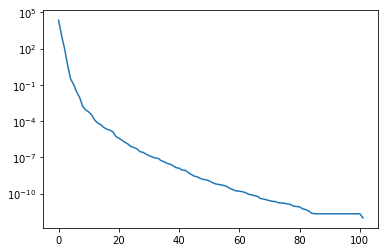

In [14]:
plt.semilogy(s)

In [16]:
v[0]

array([1.54010482e-15, 2.10174943e-16, 3.45400687e-17, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

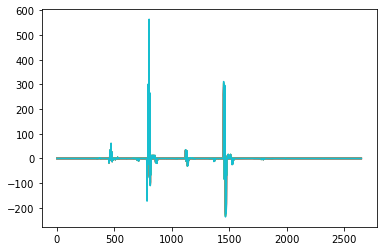

In [26]:
for i in range(10):
    plt.plot(big_matrix[i])
plt.show()

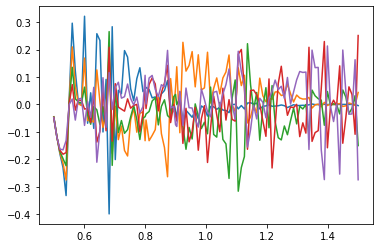

In [25]:
scales = [ float(name) for name in dir_list ]
for i in range(5):
    plt.plot(scales,u[i])
plt.show()

In [ ]:
# Five Dim Basis
basis = v[:cutpoint]

def magnet(scale):
    field = 0
    for i in range(cutpoint):
        field += u[]*v[i]



In [28]:
f = open("big_matrix.py","w")
big_matrix.write(f)
f.close()

AttributeError: 'list' object has no attribute 'write'

In [ ]:
df = pd.datafram,e